### ICN Invasive Electrophysiology tutorial 

The tutorial requires the following installed packages: 
 - numpy
 - mne 
 - matplotlib
 
For installing type 

```python
import sys
!{sys.executable} -m pip install mne
```

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import mne
import scipy.io as spio
mne.__version__

'0.22.0'

First let's choose a folder where we will create some files: 

In [2]:
import os
root = os.getcwd()
#root = r'C:\Users\richa\GitHub\MATLAB_Electrophysiology_Import\Python'

#### Data generation

Now let's create some fake data first. We will stick along with the MNE Raw Array tutorial https://mne.tools/0.11/auto_tutorials/plot_creating_data_structures.html. 
Using the MNE RawArray initialization we provide an info dictionary that can contain various aspects of the data. 
Here we specify the
 - channel names 
 - channel types 
 - sampling frequency 

In [3]:
# Generate some random data
data = np.random.randn(5, 10000)

# Initialize an info structure
info = mne.create_info(
    ch_names=['ECOG_1_L_SM_AT', 'ECOG_2_L_SM_AT', 'ECOG_3_L_SM_AT', 'ECOG_4_L_SM_AT', 'EMG_1_R_BR_TM'],
    ch_types=['ecog', 'ecog', 'ecog', 'ecog', 'emg'],
    sfreq=1000
)

custom_raw = mne.io.RawArray(data, info)
print(custom_raw)

Creating RawArray with float64 data, n_channels=5, n_times=10000
    Range : 0 ... 9999 =      0.000 ...     9.999 secs
Ready.
<RawArray | 5 x 10000 (10.0 s), ~401 kB, data loaded>


Based on this data we can plot the data stream: 
For inline plotting:  
```
%matplotlib inline 
```
For interactive window: 
```
%matplotlib qt
```


In [6]:
%matplotlib qt

In [7]:
fig = custom_raw.plot(duration=0.5, bgcolor="w", 
                scalings="auto")

Channels marked as bad: none
Attempting to create new mne-python configuration file:
C:\Users\richa\.mne\mne-python.json


### Read fieldtrip data

Now we will demonstrate the feasibility to read fieldtrip generate .mat files in python.
Scipy supports this using a io function, but accessing the struct keys is not straightforward. Luckily previous wrapper have them proposed that convert every struct element into a respective dictionary 

https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

In [8]:
# from stackoverflow answer above 

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [9]:
path_fieldtrip = r'C:\Users\richa\OneDrive - Charité - Universitätsmedizin Berlin\Data\Tutorials\MATLAB_Electrophysiology_Import\fieldtrip_sub-001_MedOff_StimOff_16-Dec-1985.mat'

In [10]:
ft = loadmat(path_fieldtrip)

In [11]:
ft

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Feb 19 16:44:32 2021',
 '__version__': '1.0',
 '__globals__': [],
 'data': {'trial': array([[  4.7727355 , -24.00878152, -24.09943197, ...,   1.81095891,
           29.26696365,  -8.00461687],
         [-10.1021783 , -54.39225997, -61.37930437, ...,   8.24986502,
           -0.43415379,  -2.24514335],
         [ 26.29846896, -37.99431375, -13.68528981, ...,  53.72061546,
           -9.53969738, -26.30481759],
         ...,
         [-26.60669239, -50.88489575, -80.07684686, ...,   5.94662928,
            6.20339614, -26.35325314],
         [-92.40098247,  55.11030907, 139.01050399, ...,  13.79530378,
           63.79531904,  19.90323634],
         [ -8.2982589 ,  19.55282177,  37.70376312, ..., -50.46715039,
          -11.97880591,   1.61190942]]),
  'time': array([0.00000000e+00, 3.57164117e-03, 7.14328234e-03, ...,
         5.99928567e+01, 5.99964284e+01, 6.00000000e+01]),
  'label': array(['LFP_0_R_STN_U', 'LFP

great! now we can simply access the fieldtrip file as a dictionary

In [12]:
ft["data"]["hdr"]["chantype"]

array(['SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'ECOG',
       'ECOG', 'ECOG', 'ECOG', 'EEG', 'EEG', 'EMG', 'EMG'], dtype=object)

So let's initialize the MNE RawArray as above and call some handy functions for basic electrophysiological signal processing

In [13]:
ft["data"]["trial"].shape

(15, 16800)

In [14]:
ft["data"]["hdr"]["chantype"]

array(['SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'SEEG', 'ECOG',
       'ECOG', 'ECOG', 'ECOG', 'EEG', 'EEG', 'EMG', 'EMG'], dtype=object)

Note that there is a difference in the supported Fieldtrip data types, so we have to convert them to lowercase 

In [91]:
info = mne.create_info(
    ch_names=list(ft["data"]["label"]),
    ch_types=list(map(lambda x:x.lower(), ft["data"]["hdr"]["chantype"])),
    sfreq=ft["data"]["hdr"]["Fs"]
)

custom_raw = mne.io.RawArray(ft["data"]["trial"], info)

Creating RawArray with float64 data, n_channels=15, n_times=16800
    Range : 0 ... 16799 =      0.000 ...    59.996 secs
Ready.


In [16]:
custom_raw.plot(scalings="auto")
plt.show()

Channels marked as bad: none


MNE offers many functionalities, we will here discuss rereferencing. For depth LFP channels bipolar referencing is commonly used (mne.set_bipolar_reference). For ECoG or EEG Common Average Referencing (CAR) is recommended. 

In [92]:
custom_raw.set_eeg_reference(ref_channels='average', ch_type='ecog')

Applying average reference.
Applying a custom ECoG reference.


<RawArray | 15 x 16800 (60.0 s), ~1.9 MB, data loaded>

In [93]:
custom_raw.info['ch_names']

['LFP_0_R_STN_U',
 'LFP_1_R_STN_U',
 'LFP_2_R_STN_U',
 'LFP_3_R_STN_U',
 'LFP_0_L_STN_U',
 'LFP_1_L_STN_U',
 'LFP_2_L_STN_U',
 'ECOG_1_U_SM_U',
 'ECOG_2_U_SM_U',
 'ECOG_3_L_SM_U',
 'ECOG_4_L_SM_U',
 'EEG_L_C3_U',
 'EEG_C_Cz_U',
 'EMG_1_R_FDI_U',
 'EMG_2_R_FDI_U']

Now let's re-reference LFP channels using a bipolar referencing scheme.
"A bipolar reference takes the difference between two channels (the anode minus the cathode) and adds it as a new virtual channel." (Source https://mne.tools/stable/generated/mne.set_bipolar_reference.html?highlight=set_bipolar_reference).

First, let us add the empty channel 'LFP_3_L_STN_U for rereferencing purposes.

In [94]:
custom_raw = mne.add_reference_channels(custom_raw, 'LFP_3_L_STN_U')
custom_raw.ch_names

['LFP_0_R_STN_U',
 'LFP_1_R_STN_U',
 'LFP_2_R_STN_U',
 'LFP_3_R_STN_U',
 'LFP_0_L_STN_U',
 'LFP_1_L_STN_U',
 'LFP_2_L_STN_U',
 'ECOG_1_U_SM_U',
 'ECOG_2_U_SM_U',
 'ECOG_3_L_SM_U',
 'ECOG_4_L_SM_U',
 'EEG_L_C3_U',
 'EEG_C_Cz_U',
 'EMG_1_R_FDI_U',
 'EMG_2_R_FDI_U',
 'LFP_3_L_STN_U']


Let's define our right anodes, cathodes and new channel names.

In [95]:
anodes_right = custom_raw.ch_names[0:3]
cathodes_right = custom_raw.ch_names[1:4]
new_ch_names_right = ['LFP_01_R_STN_U',
                     'LFP_12_R_STN_U',
                     'LFP_23_R_STN_U']

Now let's define our left anodes, cathodes and new channel names. Note that LFP_2_L_STN is already the bipolar montage we want, as LFP_3_L_STN was the original reference electrode during recording. We therefore subtract the empty reference channel LFP_3_L_STN from LFP_2_L_STN.

In [97]:
anodes_left = custom_raw.ch_names[4:6] + ['LFP_2_L_STN_U']
cathodes_left = custom_raw.ch_names[5:7] + ['LFP_3_L_STN_U']
new_ch_names_left = ['LFP_01_L_STN_U',
                     'LFP_12_L_STN_U',
                     'LFP_23_L_STN_U']

Now let us do the actual rereferencing

In [98]:
anodes = anodes_right + anodes_left
cathodes = cathodes_right + cathodes_left
new_ch_names = new_ch_names_right + new_ch_names_left
custom_raw = mne.set_bipolar_reference(custom_raw, anodes, cathodes, new_ch_names,
                                        drop_refs=True)

EEG channel type selected for re-referencing
Bipolar channel added as "LFP_01_R_STN_U".
EEG channel type selected for re-referencing
Bipolar channel added as "LFP_12_R_STN_U".
EEG channel type selected for re-referencing
Bipolar channel added as "LFP_23_R_STN_U".
EEG channel type selected for re-referencing
Bipolar channel added as "LFP_01_L_STN_U".
EEG channel type selected for re-referencing
Bipolar channel added as "LFP_12_L_STN_U".
EEG channel type selected for re-referencing
Bipolar channel added as "LFP_23_L_STN_U".


Now, let's inspect our new bipolar channel montage.

In [100]:
custom_raw.ch_names

['LFP_01_R_STN_U',
 'LFP_12_R_STN_U',
 'LFP_23_R_STN_U',
 'LFP_01_L_STN_U',
 'LFP_12_L_STN_U',
 'LFP_23_L_STN_U',
 'ECOG_1_U_SM_U',
 'ECOG_2_U_SM_U',
 'ECOG_3_L_SM_U',
 'ECOG_4_L_SM_U',
 'EEG_L_C3_U',
 'EEG_C_Cz_U',
 'EMG_1_R_FDI_U',
 'EMG_2_R_FDI_U']

Now let's explore some functions of the MNE RawArray. First plot a PSD of the average channel types: 

In [64]:
custom_raw.reorder_channels(sorted(custom_raw.ch_names))

<RawArray | 14 x 16800 (60.0 s), ~1.8 MB, data loaded>

In [65]:
custom_raw.ch_names

['ECOG_1_U_SM_U',
 'ECOG_2_U_SM_U',
 'ECOG_3_L_SM_U',
 'ECOG_4_L_SM_U',
 'EEG_C_Cz_U',
 'EEG_L_C3_U',
 'EMG_1_R_FDI_U',
 'EMG_2_R_FDI_U',
 'LFP_01_L_STN_U',
 'LFP_01_R_STN_U',
 'LFP_02_L_STN_U',
 'LFP_12_R_STN_U',
 'LFP_23_L_STN_U',
 'LFP_23_R_STN_U']

In [24]:
custom_raw.plot_psd(average=True)
plt.show()

Effective window size : 7.314 (s)
Effective window size : 7.314 (s)
Effective window size : 7.314 (s)


Next plot a time frequency plot. Note, MNE only supports time frequency plots for data with specified events (e.g. button press). Therefore we will use here the scipy signal function: 

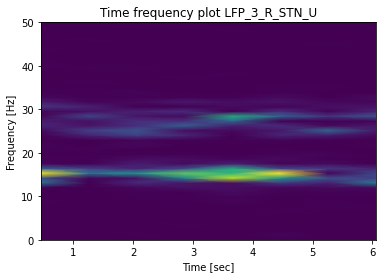

In [107]:
from scipy import signal
f, t, Sxx = signal.spectrogram(custom_raw.get_data()[3,:2000], custom_raw.info["sfreq"])
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim(0, 50)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title("Time frequency plot "+str(custom_raw.ch_names[3]))
plt.show()